In [2]:
import pandas as pd

from surprise import KNNBasic
from surprise import Dataset                                                     
from surprise import Reader                                                      
from surprise import dump
from surprise.accuracy import rmse

import pickle

import plotly.offline as plot
import plotly.plotly as py
import plotly.graph_objs as go
plot.offline.init_notebook_mode(connected=True)



from __future__ import (absolute_import, division, print_function,             
                        unicode_literals)                                      

import os





In [3]:
# Now, let's load the dataset
train_file = os.path.expanduser('~') + '/.surprise_data/ml-100k/ml-100k/u1.base'
test_file = os.path.expanduser('~') + '/.surprise_data/ml-100k/ml-100k/u1.test'
data = Dataset.load_from_folds([(train_file, test_file)], Reader('ml-100k'))

                
# We'll use a basic nearest neighbor approach, where similarities are computed
# between users.
algo = KNNBasic()                                                       

for trainset, testset in data.folds(): 
    algo.train(trainset)                             
    predictions = algo.test(testset)
    rmse(predictions)
                                                                               
dump('./dump_file', predictions, trainset, algo)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9889
The dump has been saved as file ./dump_file


In [4]:
# The dump has been saved and we can now use it whenever we want.
# Let's load it and see what we can do
dump_obj = pickle.load(open('./dump_file', 'rb'))

In [5]:
predictions = dump_obj['predictions']
trainset = dump_obj['trainset']
algo = dump_obj['algo']
print('algo: {0}, k = {1}, min_k = {2}'.format(algo['name'], algo['k'], algo['min_k']))

algo: KNNBasic, k = 40, min_k = 1


In [6]:
df = pd.DataFrame(predictions)

In [7]:
# Let's build a pandas dataframe with all the predictions

def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [8]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [9]:
# Let's take a look at the best predictions of the algorithm
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
272,5,439,1.0,1.0,"{'actual_k': 3, 'was_impossible': False}",91,3,0.0
886,13,314,1.0,1.0,"{'actual_k': 2, 'was_impossible': False}",373,2,0.0
156,2,314,1.0,1.0,"{'actual_k': 2, 'was_impossible': False}",40,2,0.0
926,13,437,1.0,1.0,"{'actual_k': 3, 'was_impossible': False}",373,3,0.0
9276,206,314,1.0,1.0,"{'actual_k': 1, 'was_impossible': False}",33,2,0.0
19118,405,437,1.0,1.0,"{'actual_k': 3, 'was_impossible': False}",582,3,0.0
8032,181,1334,1.0,1.0,"{'actual_k': 1, 'was_impossible': False}",218,1,0.0
8041,181,1354,1.0,1.0,"{'actual_k': 1, 'was_impossible': False}",218,1,0.0
9202,201,1424,3.0,3.0,"{'actual_k': 1, 'was_impossible': False}",215,1,0.0
3018,60,1123,4.0,4.0,"{'actual_k': 1, 'was_impossible': False}",119,1,0.0


In [11]:
# Now, let's look at the prediction with the biggest error
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
9406,208,302,1.0,4.308447,"{'actual_k': 40, 'was_impossible': False}",11,245,3.308447
19089,405,169,1.0,4.364728,"{'actual_k': 40, 'was_impossible': False}",582,97,3.364728
19785,436,132,1.0,4.365369,"{'actual_k': 40, 'was_impossible': False}",126,200,3.365369
157,2,315,1.0,4.381308,"{'actual_k': 40, 'was_impossible': False}",40,136,3.381308
8503,193,56,1.0,4.386478,"{'actual_k': 40, 'was_impossible': False}",61,312,3.386478
5531,113,976,5.0,1.610771,"{'actual_k': 7, 'was_impossible': False}",31,7,3.389229
7917,181,408,1.0,4.421499,"{'actual_k': 40, 'was_impossible': False}",218,93,3.421499
7390,167,169,1.0,4.664991,"{'actual_k': 40, 'was_impossible': False}",38,97,3.664991
7412,167,1306,5.0,1.000000,"{'actual_k': 1, 'was_impossible': False}",38,1,4.000000
5553,114,1104,5.0,1.000000,"{'actual_k': 1, 'was_impossible': False}",27,1,4.000000


<IPython.core.display.Javascript object>


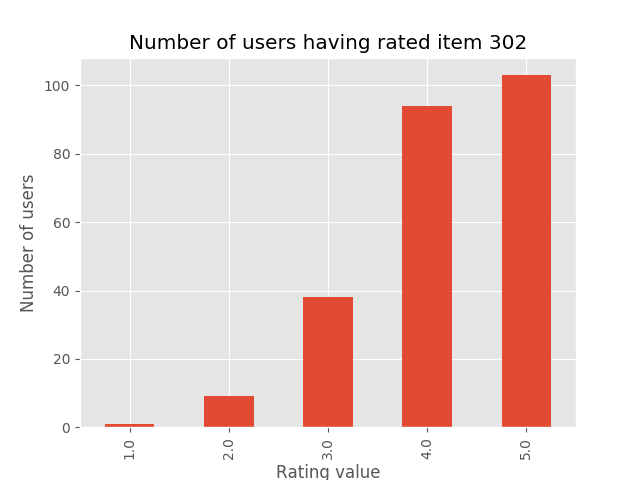

In [14]:
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
matplotlib.style.use('ggplot')

counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid('302')]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of users')
plt.title('Number of users having rated item 302')

## Histogram frequency ##

In [15]:
data = [go.Histogram(x=df.est - df.rui)]
layout = go.Layout(
    title='FREQUENCY OF RESIDUALS',
    xaxis=dict(
        title='RESIDUALS'
    ),
    yaxis=dict(
        title='FREQUENCY'
    )
)
fig = go.Figure(data=data, layout=layout)
plot.iplot(fig, filename='residuals')

## Box Plot ##

In [16]:
data = [go.Box(y=df.est - df.rui)]
layout = go.Layout(
    title='FREQUENCY OF RESIDUALS',
    xaxis=dict(
        title='RESIDUALS'
    ),
    yaxis=dict(
        title='FREQUENCY'
    )
)
fig = go.Figure(data=data, layout=layout)
plot.iplot(fig, filename='residuals')